In [7]:
import pandas as pd
from IPython.display import Image
from pgmpy.models import BayesianNetwork

In [12]:
msmt_feedback = pd.read_csv("msmt_feedback.csv", delimiter='\t', names=['measurement_uid', 'user_id', 'status', 'comment'])

In [26]:
msmt_feedback['status'].unique()

array(['blocked', 'down.unreachable', 'ok', 'blocked.blockpage.dns',
       'blocked.dns.nxdomain', 'blocked.dns.inconsistent',
       'blocked.blockpage.server_side', 'blocked.tcp', 'blocked.tls',
       'blocked.blockpage.http', 'down.misconfigured',
       'blocked.blockpage', 'down', 'blocked.dns'], dtype=object)

In [28]:
def map_outcome(status):
    if status.startswith('ok'):
        return 'ok'
    elif status.startswith('blocked'):
        return 'blocked'
    elif status.startswith('down'):
        return 'down'
msmt_feedback['outcome'] = msmt_feedback['status'].apply(map_outcome)

In [30]:
msmt_feedback[['measurement_uid', 'status', 'outcome']].to_csv('msmt_feedback_clean.csv')

In [2]:
web_analysis_bn = BayesianNetwork([
    ('DNS VP Failures', 'DNS Outcome'),
    ('DNS VP Failures', 'VP State'),
    ('DNS Ctrl Failures', 'DNS Outcome'),
    ('DNS Ctrl Failures', 'DNS VP Failures'),
    ('Resolver config', 'DNS Outcome'),
    ('DNS Consistency', 'DNS Outcome'),
    ('DNS Answer Meta', 'DNS Consistency'),
    ('DNS TLS Consistency', 'DNS Consistency'),
    ('DNS VP Got Answer', 'DNS Outcome'),
    ('Resolver Config', 'DNS Consistency'),
    ('Resolver Config', 'VP State'),
    ('DNS Outcome', 'TCP VP Failures'),
    ('TCP VP Failures', 'TCP Outcome'),
    ('TCP Ctrl Failures', 'TCP Outcome'),
    ('TCP Outcome', 'TLS VP Failures'),
    ('TCP Outcome', 'HTTP Failure'),
    ('TLS VP Failures', 'TLS Outcome'),
    ('TLS VP Failures', 'VP State'),

    ('TLS Ctrl Failures', 'TLS Outcome'),
    ('TLS Outcome', 'HTTP Failures'),
    ('HTTP Failures', 'HTTP Outcome'),
    ('HTTP Failures', 'VP State'),
    ('HTTP Body Consistency', 'HTTP Response is plaintext'),
    ('HTTP Response is plaintext', 'HTTP Outcome'),
])

In [6]:
#web_analysis_bn.save('web_analysi.bif')

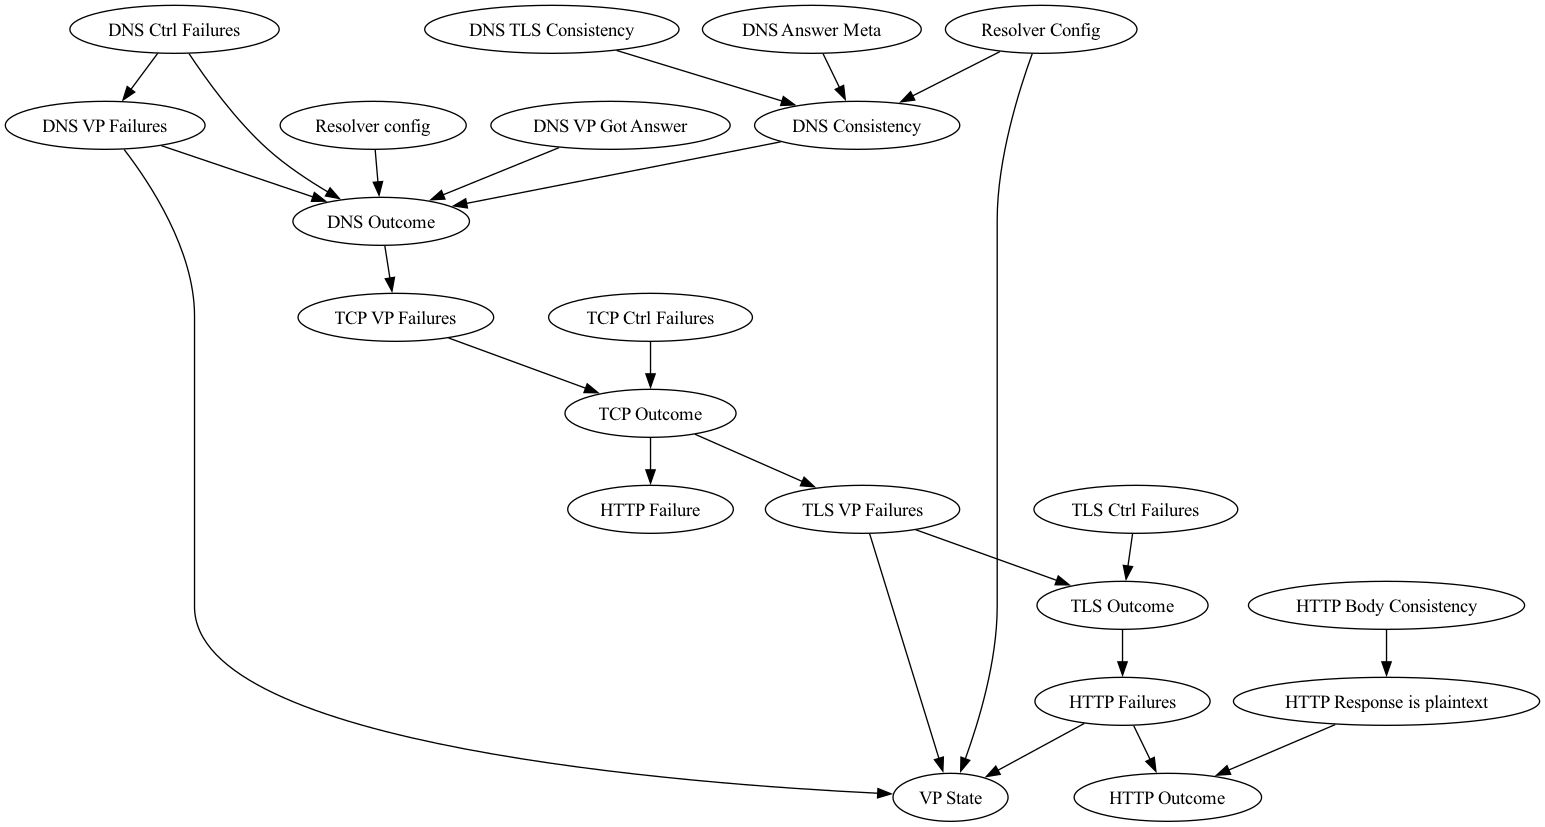

In [3]:
viz = web_analysis_bn.to_graphviz()
viz.draw('web_analysis.png', prog='dot')
Image('web_analysis.png')

In [ ]:
cpd_dns_ctrl_failure = TabularCPD('A', 2, [[0.2], [0.8]])

In [49]:
list(web_analysis_bn.nodes)[0]

'DNS VP Failures'

In [52]:
child = list(web_analysis_bn.nodes)[0]
child

'DNS VP Failures'

In [53]:
web_analysis_bn.get_parents(child)

['DNS Ctrl Failures']

In [67]:
def print_boilerplate():
    cpd_list = []
    for x in list(web_analysis_bn.nodes):
        var_name = x.lower().replace(' ', '_')
        var_name = f"cpd_{var_name}"
        s = f"{var_name} = TabularCPD('{x}', variable_card=2, values=[\n"
        parents = web_analysis_bn.get_parents(x)
        padding = " "*(int(len(s)/2))
        for _ in range(2):
            s += padding + "["
            s += ",".join("0." for x in range(len(parents)))
            s += "],\n"
        s += padding + f"],\n" 
        s += padding + f" # parents={parents}\n"
        s += padding + f"evidence={parents},\n"
        s += padding + f"evidence_card=[],\n"
        s += padding + "state_names = {\n"
        for p in parents:
            s += padding + f"'{p}': [],\n"
        s += "}\n"
        s += padding + ")"
        print(s)
        cpd_list.append(var_name)

In [68]:
cpd_dns_ctrl_failures = TabularCPD(
    "DNS Ctrl Failures",
    variable_card=3,
    values=[
        [0.8],
        [0.15],
        [0.05],
    ],
    state_names={
        "DNS Ctrl Failures": ["none", "nxdomain", "server_failure"]
    },
)
cpd_dns_vp_failures = TabularCPD(
    "DNS VP Failures",
    variable_card=3,
    values=[
        [0.8],
        [0.15],
        [0.05],
    ],
    evidence=["DNS Ctrl Failures"],
    evidence_card=[3],
    state_names={
        "DNS VP Failures": ["none", "nxdomain", "server_failure"],
        "DNS Ctrl Failures": ["none", "nxdomain", "server_failure"],
    },
)
cpd_resolver_config = TabularCPD(
    "Resolver config",
    variable_card=3,
    values=[
        # These values were estimated based on a query against the OONI dataset from 2024-01-01 to 2024-08-10
        # with this query:
        # -- ## quad_resolvers
        # --    15169, # Google LLC
        # --    13335, # Cloudflare Inc
        # --    42, # WoodyNet, Inc. | quad9
        # --    36692, # Cisco OpenDNS, LLC	
        # SELECT 
        # CountIf(resolver_asn IN (15169, 13335, 42, 36692)) as quad_external_count,
        # CountIf( 
        #     (resolver_asn = probe_asn OR resolver_as_cc = probe_cc) 
        #     AND NOT (resolver_asn IN (15169, 13335, 42, 36692)) 
        # ) as provider_vp_consistent,
        # CountIf( 
        #     (resolver_asn != probe_asn AND resolver_as_cc != probe_cc) 
        #     AND NOT (resolver_asn IN (15169, 13335, 42, 36692)) 
        # ) as provider_non_vp_consistent,
        # COUNT() as total_count
        # FROM obs_web
        # WHERE 
        # measurement_start_time > '2024-01-01' 
        # AND measurement_start_time < '2024-08-10'
        [0.56],
        [0.08],
        [0.36],
    ],
    state_names={
        # provider_vp_consistent: means the resolver is consistent with the country and/or AS of the probe and is 
        #   not a quad (eg. 8.8.8.8, 9.9.9.9, etc.) or third party resolver
        # provider_non_vp_consistent: means the resolver is not a quad resolver, 
        #   but is not consistent with the metadata of the probe
        # quad_external: means the resolver is something like quad9, google, cloudflare, etc.
        "Resolver config": ["provider_vp_consistent", "provider_non_vp_consistent", "quad_external"]
    },
)
cpd_dns_answer_meta = TabularCPD(
    "DNS Answer Meta",
    variable_card=6,
    # These values were calculated using the following query.
    # WITH
    #     (dns_answer IS NOT NULL 
    #     AND ip_asn IN (13335, 209242, 20940, 9002, 16625, 63949, 16509, 14618, 15169, 396982, 54113, 8075, 8068)
    #     ) as is_cloud_provider
    # SELECT 
    # CountIf(is_cloud_provider) as cloud_provider,
    # CountIf(
    # dns_answer IS NOT NULL AND ip_is_bogon AND NOT is_cloud_provider
    # ) as answer_is_bogon,
    # CountIf(
    #     dns_answer IS NOT NULL AND ip_asn = probe_asn AND NOT is_cloud_provider
    # ) as answer_matches_probe_asn,
    # CountIf(
    #     dns_answer IS NOT NULL AND (ip_cc = probe_cc AND NOT ip_asn = probe_asn AND NOT is_cloud_provider)
    # ) as answer_matches_probe_cc,
    # CountIf(
    #     dns_answer IS NOT NULL AND (ip_cc != probe_cc AND ip_asn != probe_asn AND NOT ip_is_bogon AND NOT is_cloud_provider)
    # ) as answer_ok,
    # COUNTIf(dns_failure IS NOT NULL) as dns_failure,
    # COUNT() as total_count
    # FROM obs_web
    # WHERE 
    # test_name = 'web_connectivity'
    # AND measurement_start_time > '2024-01-01' 
    # AND measurement_start_time < '2024-08-10'
    ## The list of cloud providers was manually curated
    # CLOUD_PROVIDERS_ASNS = [
    #    13335,  # Cloudflare: https://www.peeringdb.com/net/4224
    #    209242, #	Cloudflare London, LLC	
    #    20940,  # Akamai: https://www.peeringdb.com/net/2
    #    9002,  # Akamai RETN
    #    16625, # Akamai Technologies, Inc.	
    #    63949, # Akamai Technologies, Inc.	
    #    16509, #	Amazon.com, Inc.
    #    14618, #	Amazon.com, Inc.	
    #    15169, #	Google LLC
    #    396982,  # Google Cloud: https://www.peeringdb.com/net/30878
    #    54113, #	Fastly, Inc
    #    8075, # Microsoft Corporation
    #    8068, #	Microsoft Corporation
    # ]
    values=[
        [0.034306],
        [0.003745],
        [0.004537],
        [0.060217],
        [0.19626],
        [0.700935]
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={
        "DNS Answer Meta": [
            "answer_failure", 
            "answer_is_bogon", 
            "answer_matches_probe_asn", 
            "answer_matches_probe_cc",
            "answer_is_cloud_provider",
            "answer_ok"
        ],
    },
)
cpd_dns_tls_consistency = TabularCPD(
    "DNS TLS Consistency",
    variable_card=2,
    values=[
        [],
        [],
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={
        "DNS TLS Consistency": [""]
    },
)
cpd_dns_consistency = TabularCPD(
    "DNS Consistency",
    variable_card=2,
    values=[
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
    ],
    # parents={parents}
    evidence=["DNS Answer Meta", "DNS TLS Consistency", "Resolver Config"],
    evidence_card=[],
    state_names={
        "DNS Consistency": [],
        "DNS Answer Meta": [
            "answer_failure", 
            "answer_is_bogon", 
            "answer_matches_probe_asn", 
            "answer_matches_probe_cc",
            "answer_is_cloud_provider",
            "answer_ok"
        ],
        "DNS TLS Consistency": [],
        "Resolver config": ["provider_vp_consistent", "provider_non_vp_consistent", "quad_external"]
    },
)
cpd_dns_outcome = TabularCPD(
    "DNS Outcome",
    variable_card=2,
    values=[
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
    ],
    # parents={parents}
    evidence=[
        "DNS VP Failures",
        "DNS Ctrl Failures",
        "Resolver config",
        "DNS Consistency",
        "DNS VP Got Answer",
    ],
    evidence_card=[],
    state_names={
        "DNS VP Failures": ["none", "nxdomain", "server_failure"],
        "DNS Ctrl Failures": ["none", "nxdomain", "server_failure"],
        "Resolver config": ["provider_vp_consistent", "provider_non_vp_consistent", "quad_external"]
        "DNS Consistency": [],
        "DNS VP Got Answer": [],
    },
)
cpd_vp_state = TabularCPD(
    "VP State",
    variable_card=2,
    values=[
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
    ],
    # parents={parents}
    evidence=["DNS VP Failures", "Resolver Config", "TLS VP Failures", "HTTP Failures"],
    evidence_card=[],
    state_names={
        "DNS VP Failures": [],
        "Resolver Config": [],
        "TLS VP Failures": [],
        "HTTP Failures": [],
    },
)
cpd_dns_vp_got_answer = TabularCPD(
    "DNS VP Got Answer",
    variable_card=2,
    values=[
        [],
        [],
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={},
)
cpd_tcp_vp_failures = TabularCPD(
    "TCP VP Failures",
    variable_card=2,
    values=[
        [0.0],
        [0.0],
    ],
    # parents={parents}
    evidence=["DNS Outcome"],
    evidence_card=[],
    state_names={
        "DNS Outcome": [],
    },
)
cpd_tcp_outcome = TabularCPD(
    "TCP Outcome",
    variable_card=2,
    values=[
        [0.0, 0.0],
        [0.0, 0.0],
    ],
    # parents={parents}
    evidence=["TCP VP Failures", "TCP Ctrl Failures"],
    evidence_card=[],
    state_names={
        "TCP VP Failures": [],
        "TCP Ctrl Failures": [],
    },
)
cpd_tcp_ctrl_failures = TabularCPD(
    "TCP Ctrl Failures",
    variable_card=2,
    values=[
        [],
        [],
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={},
)
cpd_tls_vp_failures = TabularCPD(
    "TLS VP Failures",
    variable_card=2,
    values=[
        [0.0],
        [0.0],
    ],
    # parents={parents}
    evidence=["TCP Outcome"],
    evidence_card=[],
    state_names={
        "TCP Outcome": [],
    },
)
cpd_http_failure = TabularCPD(
    "HTTP Failure",
    variable_card=2,
    values=[
        [0.0],
        [0.0],
    ],
    # parents={parents}
    evidence=["TCP Outcome"],
    evidence_card=[],
    state_names={
        "TCP Outcome": [],
    },
)
cpd_tls_outcome = TabularCPD(
    "TLS Outcome",
    variable_card=2,
    values=[
        [0.0, 0.0],
        [0.0, 0.0],
    ],
    # parents={parents}
    evidence=["TLS VP Failures", "TLS Ctrl Failures"],
    evidence_card=[],
    state_names={
        "TLS VP Failures": [],
        "TLS Ctrl Failures": [],
    },
)
cpd_tls_ctrl_failures = TabularCPD(
    "TLS Ctrl Failures",
    variable_card=2,
    values=[
        [],
        [],
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={},
)
cpd_http_failures = TabularCPD(
    "HTTP Failures",
    variable_card=2,
    values=[
        [0.0],
        [0.0],
    ],
    # parents={parents}
    evidence=["TLS Outcome"],
    evidence_card=[],
    state_names={
        "TLS Outcome": [],
    },
)
cpd_http_outcome = TabularCPD(
    "HTTP Outcome",
    variable_card=2,
    values=[
        [0.0, 0.0],
        [0.0, 0.0],
    ],
    # parents={parents}
    evidence=["HTTP Failures", "HTTP Response is plaintext"],
    evidence_card=[],
    state_names={
        "HTTP Failures": [],
        "HTTP Response is plaintext": [],
    },
)
cpd_http_body_consistency = TabularCPD(
    "HTTP Body Consistency",
    variable_card=2,
    values=[
        [],
        [],
    ],
    # parents={parents}
    evidence=[],
    evidence_card=[],
    state_names={},
)
cpd_http_response_is_plaintext = TabularCPD(
    "HTTP Response is plaintext",
    variable_card=2,
    values=[
        [0.0],
        [0.0],
    ],
    # parents={parents}
    evidence=["HTTP Body Consistency"],
    evidence_card=[],
    state_names={
        "HTTP Body Consistency": [],
    },
)

NameError: name 'TabularCPD' is not defined